# Searching for TSP solutions
The notebook includes code to load a datafile of 115,475 cities in the US and run a hill-climbing algorithm in attempt to find a short tour of all the cities.

In [2]:
import numpy as np
from numba import jit
import matplotlib.pyplot as plt
import math
import time
from sklearn.cluster import KMeans
import random as rn
import numpy as np
from numpy.random import choice as np_choice
from numpy import inf

### Load and plot data

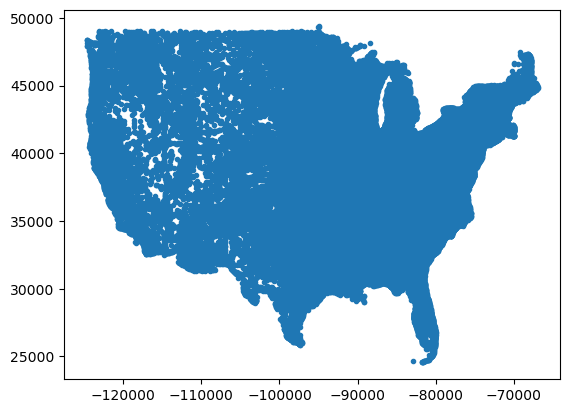

In [3]:
with open("cities.csv") as datafile:
    data = np.loadtxt(datafile, delimiter=" ")[:,1:] # chop of city indices

N = len(data)

CITIES = np.zeros((N,2))
CITIES[:,0] = -data[:,1]
CITIES[:,1] = data[:,0]

plt.plot(CITIES[:,0],CITIES[:,1],'.');

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


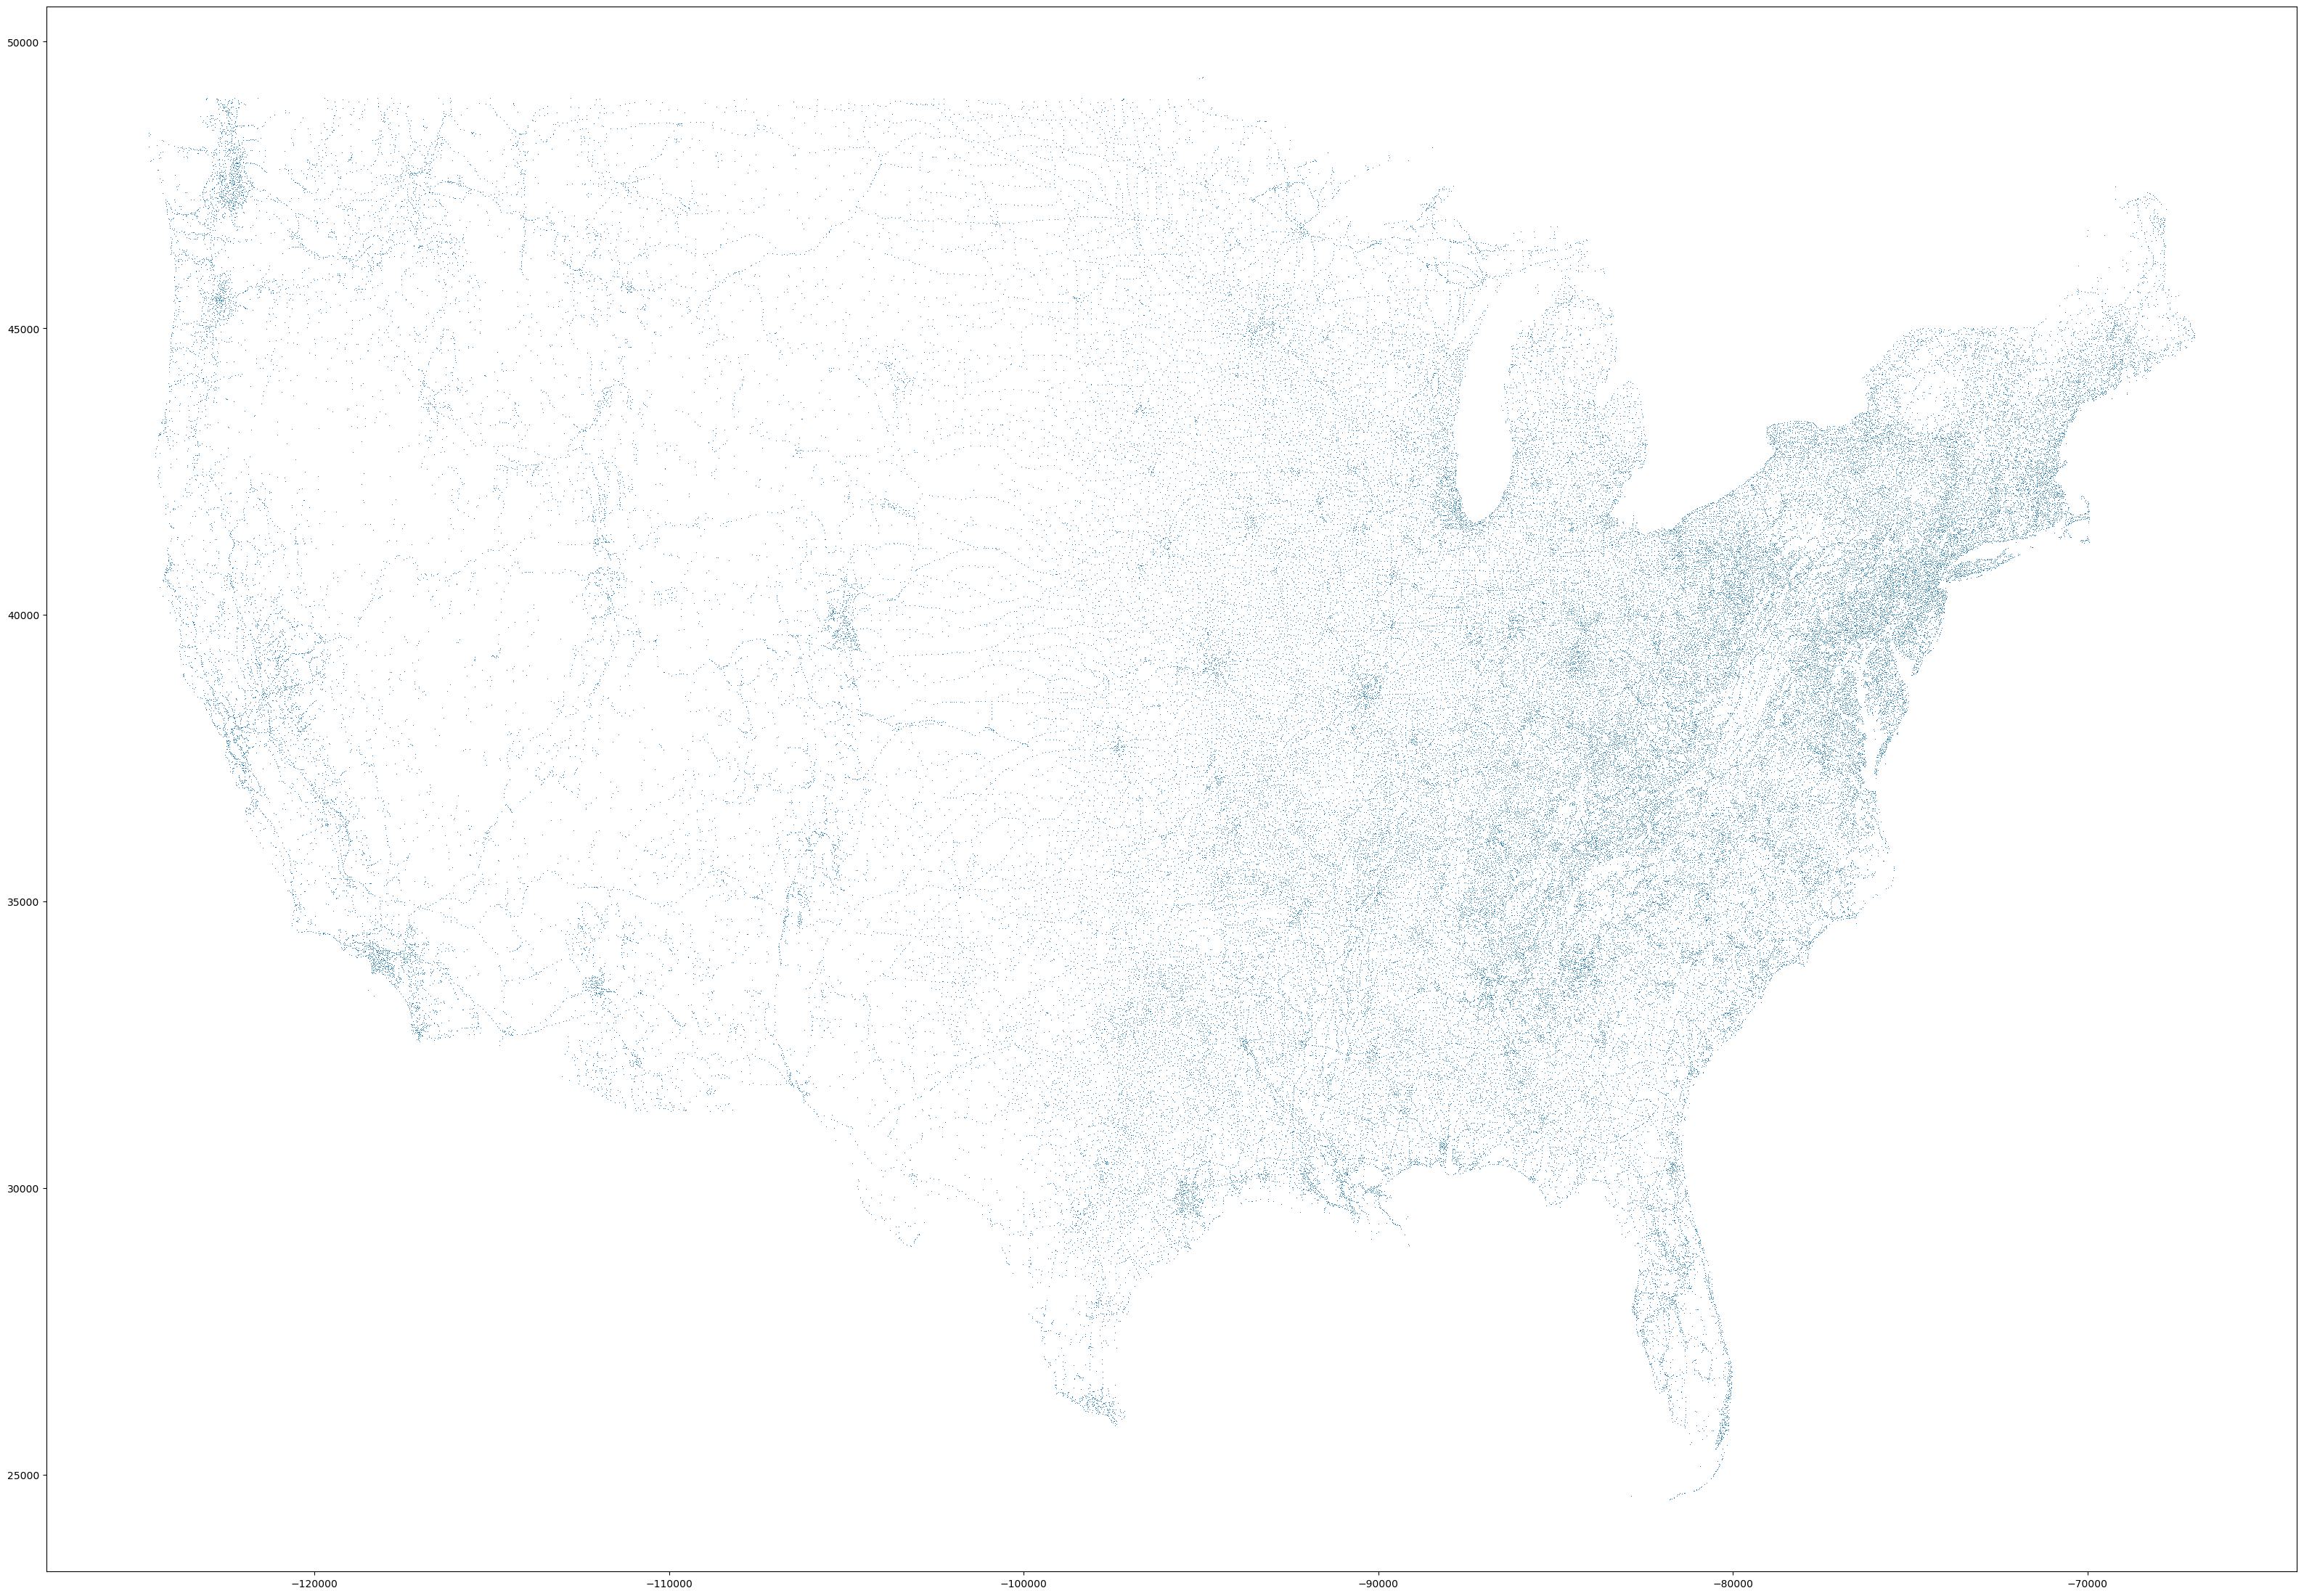

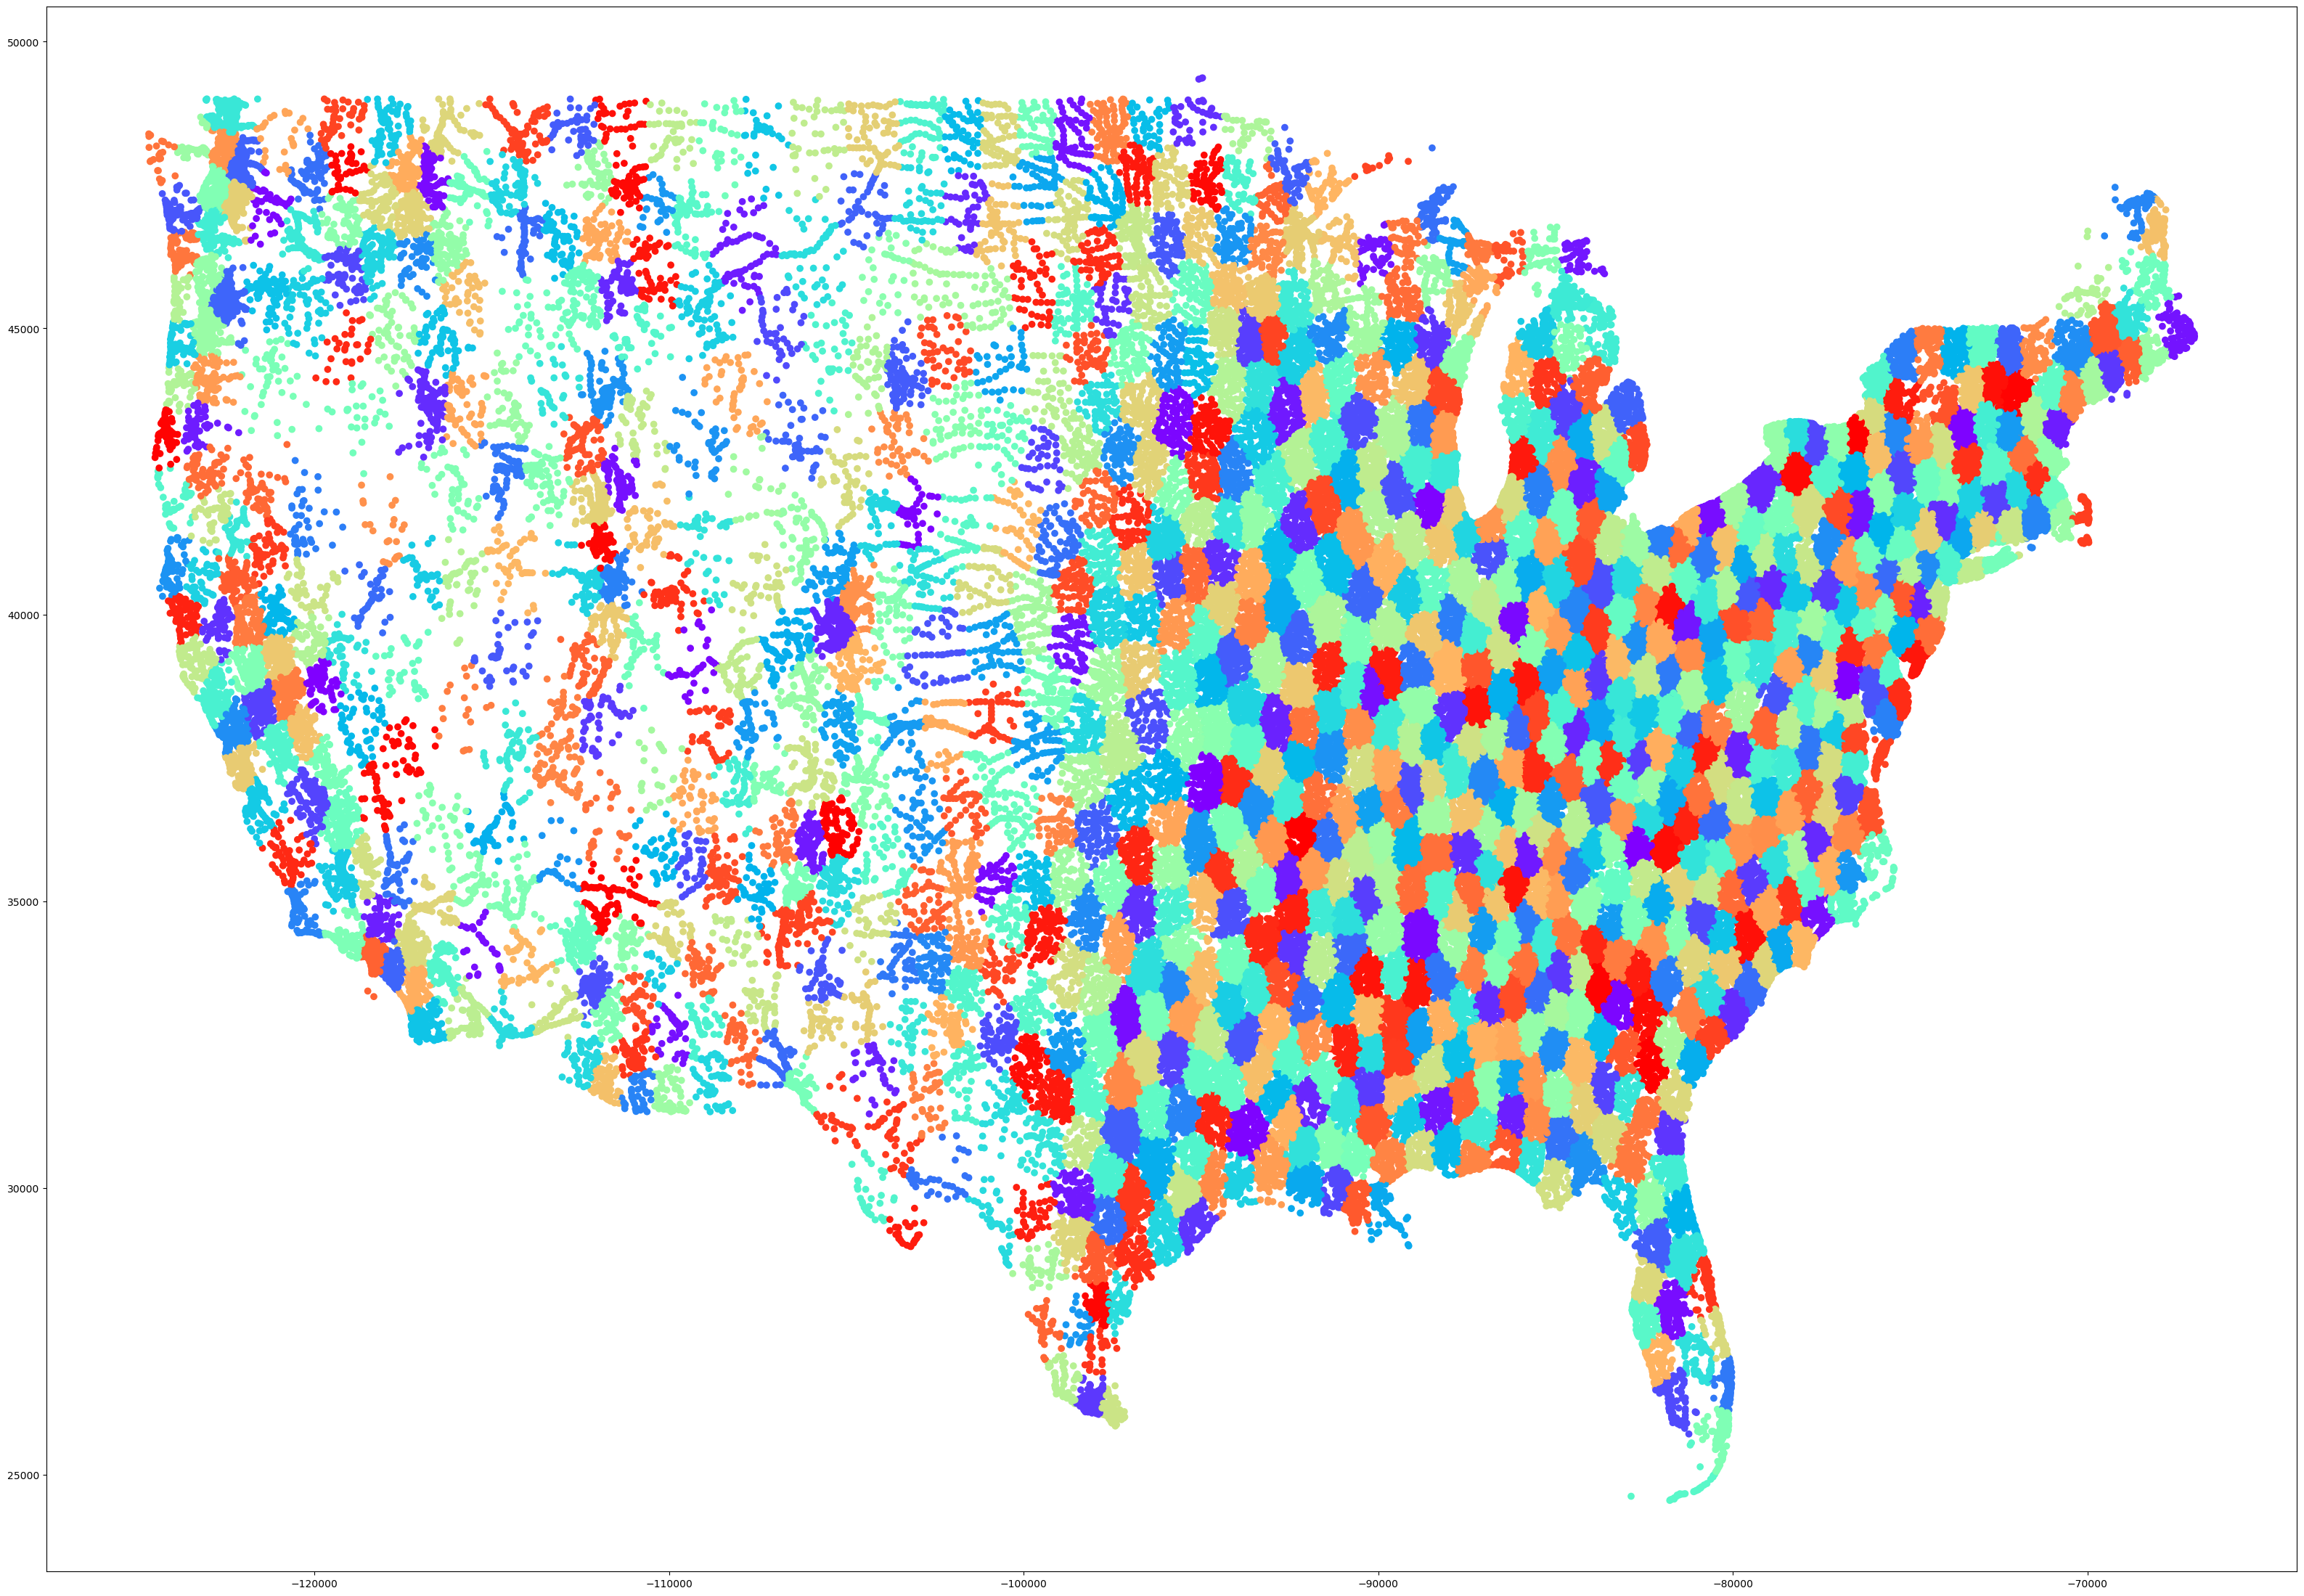

In [4]:
CITIES = np.zeros((N,2))
CITIES[:,0] = -data[:,1]
CITIES[:,1] = data[:,0]

means = 1000
plt.figure(figsize=(40,28), dpi=100)
plt.plot(CITIES[:,0],CITIES[:,1], ',');
kmeans = KMeans(n_clusters=means)
kmeans.fit(CITIES)
plt.figure(figsize=(40,28),dpi=100)
plt.scatter(CITIES[:,0],CITIES[:,1], c=kmeans.labels_, cmap='rainbow')
plt.show()

In [5]:
neighborhood_indexes = []
neighborhood_coords = []
for i in range(means):
    neighborhood_indexes.append(np.array([]))
    neighborhood_coords.append([])
for i in range(len(CITIES)):
    neighborhood_indexes[kmeans.labels_[i]] = np.append(neighborhood_indexes[kmeans.labels_[i]], i)
    neighborhood_coords[kmeans.labels_[i]].append(CITIES[i])

In [6]:
#print(neighborhood_coords[0])
print(len(neighborhood_coords[0]))

177


In [7]:
def dist(city_i,city_j):
    return math.sqrt((city_i[0]-city_j[0])**2 + (city_i[1]-city_j[1])**2)

# assuming order is a permutation of the integers {0,...,N-1}, calculate associated tour length
def tour_length(cities,tour):
    n = len(cities)
    length = 0
    for i in range(1,n): # add dist(i-1,i)
        length += dist(cities[tour[i-1],:],cities[tour[i],:])
    return length + dist(cities[tour[0],:],cities[tour[n-1],:])

# swaps two values in arr, based on the indices specified by pair
def swap(arr,pair):
    o_i = arr[pair[0]]
    arr[pair[0]]=arr[pair[1]]
    arr[pair[1]]=o_i

# checks that no single swap improves the given tour
def is_local_opt(cities,tour):
    curr = tour_length(cities,tour)
    for i in range(1,len(cities)):
        for j in range(1,i):
            p=(i,j)
            swap(tour,p)
            if tour_length(cities,tour)<curr:
                return False
            swap(tour,p)
    return True

# print the distance if visiting cities in the order 0,2,...,N-1,0
print("Length of in-order tour of",len(CITIES),"cities:",tour_length(CITIES,np.array(range(len(CITIES)))))
print("Is locally optimal?",is_local_opt(CITIES,np.array(range(len(CITIES)))))

Length of in-order tour of 115475 cities: 213920969.00611648
Is locally optimal? False


In [8]:
total_average=[]
for i in range(means):
    neighborhood = i
    average=neighborhood_coords[neighborhood][0]
    total=[0,0]
    for j in range(len(neighborhood_coords[neighborhood])):
        total+=neighborhood_coords[neighborhood][j]
        average=total/len(neighborhood_coords[neighborhood])
    total_average.append(average)
print(total_average,len(total_average))


[array([-82677.18363277,  35983.31183446]), array([-119845.39013827,   38828.64361975]), array([-94783.47728521,  37094.96597988]), array([-76799.16394378,  38819.57441676]), array([-103119.86203778,   41735.04029778]), array([-88469.35611438,  41908.97900137]), array([-73518.35567806,  43223.74895806]), array([-93699.93279928,  31005.02807174]), array([-121294.01450213,   47157.51331915]), array([-109257.7878   ,   39150.6286375]), array([-83254.82786139,  33159.45722376]), array([-95740.86146778,  43359.08332333]), array([-88801.31072562,  34409.0514734 ]), array([-86152.58329947,  39854.13249358]), array([-100804.70994419,   35376.30699302]), array([-116708.24783684,   47619.13399579]), array([-80604.28619595,  41710.19827297]), array([-81736.83304171,  27928.07173618]), array([-115300.27034,   34213.80726]), array([-97121.12721   ,  32950.43351278]), array([-90216.32511024,  38641.27555268]), array([-111417.029625  ,   42330.17880781]), array([-109894.51706977,   32769.0791814 ]), 

In [9]:
q=0
order=[total_average[0]]
start = total_average[0]
copy_average=[]
for i in range(len(total_average)):
    copy_average.append(total_average[i])
copy_average.pop(0)
final_length=0
for j in range(means-1):
    l=100000
    for i in range(len(copy_average)):
        d = dist(start, copy_average[i])
        if (d<l and d != 0):
            l = d
            close = copy_average[i]
            q=i
    start = close
    order.append(copy_average[q])
    del copy_average[q]
print(order, len(order), len(total_average))



[array([-82677.18363277,  35983.31183446]), array([-82401.36939559,  36452.3608674 ]), array([-82338.847225  ,  37003.91839111]), array([-82643.92654386,  37447.74457485]), array([-83046.27175729,  37036.71119196]), array([-83131.36648713,  36435.84246257]), array([-83446.33577513,  35998.59641799]), array([-83970.68786255,  35919.89003447]), array([-84415.11166782,  36328.04839195]), array([-83803.25140168,  36730.46426134]), array([-84005.08735539,  37461.68236716]), array([-83509.73455829,  37455.25471497]), array([-83112.65512931,  37887.71545431]), array([-83114.48195912,  38560.48720189]), array([-82525.96122347,  38268.15283827]), array([-82448.60639392,  38899.85735249]), array([-81803.94166791,  38973.74801123]), array([-82050.06228956,  39522.70337912]), array([-81784.16752057,  40121.64652411]), array([-81266.69161667,  39812.40547011]), array([-81215.52990462,  39293.14407077]), array([-81156.3600096 ,  38684.76092677]), array([-81198.28023258,  38004.79987285]), array([-80

In [10]:
order_indexes=[]
for j in range (means):
    for i in range (len(order)):
        if(order[j][0] == total_average[i][0] and order[j][1] == total_average[i][1]):
            order_indexes.append(i)
print(order_indexes)

[0, 324, 544, 80, 464, 803, 526, 282, 605, 117, 470, 939, 377, 359, 286, 631, 163, 765, 979, 28, 813, 567, 133, 958, 830, 274, 462, 895, 116, 585, 363, 223, 445, 856, 764, 16, 726, 233, 450, 607, 53, 330, 638, 284, 389, 868, 356, 111, 611, 416, 577, 291, 620, 3, 707, 176, 780, 562, 438, 941, 431, 810, 479, 250, 455, 598, 885, 43, 635, 187, 402, 228, 621, 700, 82, 429, 209, 383, 6, 658, 933, 515, 61, 701, 307, 93, 180, 731, 996, 668, 406, 963, 165, 836, 247, 443, 976, 992, 593, 36, 532, 938, 456, 547, 919, 178, 322, 853, 640, 477, 306, 461, 792, 891, 715, 129, 815, 435, 821, 571, 72, 877, 548, 349, 887, 600, 191, 467, 727, 179, 24, 855, 971, 252, 492, 137, 788, 189, 905, 27, 524, 256, 525, 92, 332, 540, 987, 662, 413, 485, 48, 566, 161, 171, 622, 823, 194, 446, 328, 555, 619, 879, 224, 449, 903, 126, 651, 238, 85, 931, 293, 750, 404, 965, 372, 807, 42, 465, 777, 316, 177, 785, 275, 779, 74, 738, 921, 102, 898, 751, 516, 970, 908, 136, 579, 774, 948, 507, 396, 50, 230, 878, 210, 655, 34,

In [11]:
final_tour=[]
def node(p):
    neighborhood = p

    n_cities = len(neighborhood_coords[neighborhood])
    distance = np.zeros((n_cities,n_cities))
    iteration = 20
    n_ants = n_cities

    def dist(city_i,city_j):
        return math.sqrt((city_i[0]-city_j[0])**2 + (city_i[1]-city_j[1])**2)


    m = n_ants
    n = n_cities
    e = .5         #evaporation rate
    alpha = 1      #pheromone factor
    beta = 2       #visibility factor



    pheromne = .1*np.ones((m,n))

    route = np.ones((m,n+1))
    for i in range(n_cities):
        for j in range(n_cities):
          distance[i][j] = dist(neighborhood_coords[neighborhood][i],neighborhood_coords[neighborhood][j])


    master_visibility = 1/distance
    master_visibility[master_visibility == inf ] = 0


    for it in range(iteration):
        route[:,0] = 1
        for i in range(m):
            temp_visibility = np.array(master_visibility)
            for j in range(n-1):

                combine_feature = np.zeros(100)
                cum_prob = np.zeros(100)

                cur_loc = int(route[i,j]-1)

                temp_visibility[:,cur_loc] = 0

                p_feature = np.power(pheromne[cur_loc,:],beta)
                v_feature = np.power(temp_visibility[cur_loc,:],alpha)


                combine_feature = np.multiply(p_feature,v_feature)
                total = np.sum(combine_feature)
                probs = combine_feature/total

                cum_prob = np.cumsum(probs)
                r = np.random.random_sample()
                city = np.nonzero(cum_prob>r)[0][0]+1

                route[i,j+1] = city


        route_opt = np.array(route)
        dist_cost = np.zeros((m,1))

        for i in range(m):
            s = 0

            for j in range(n-1):
                s = s + distance[int(route_opt[i,j])-1,int(route_opt[i,j+1])-1]
            dist_cost[i]=s

        dist_min_loc = np.argmin(dist_cost)
        dist_min_cost = dist_cost[dist_min_loc]

        best_route = route[dist_min_loc,:]
        pheromne = (1-e)*pheromne

        for i in range(m):
            for j in range(n-1):
                dt = 1/dist_cost[i]
                pheromne[int(route_opt[i,j])-1,int(route_opt[i,j+1])-1] = pheromne[int(route_opt[i,j])-1,int(route_opt[i,j+1])-1] + dt

    length = int(dist_min_cost[0])
    for i in range(len(route_opt)):
        final_tour.append(neighborhood_coords[p][int(best_route[i])-1])
    print(p)
    return length

In [12]:
for l in range(means):
    final_length+=node(order_indexes[l])
#This is not the actual final length. That is lower

/var/folders/8q/jzwt9rrs4bz6txvcy6scnyn80000gn/T/ipykernel_31906/1961104154.py:30: RuntimeWarning: divide by zero encountered in divide
  master_visibility = 1/distance


0
324
544
80
464
803
526
282
605
117
470
939
377
359
286
631
163
765
979
28
813
567
133
958
830
274
462
895
116
585
363
223
445
856
764
16
726
233
450
607
53
330
638
284
389
868
356
111
611
416
577
291
620
3
707
176
780
562
438
941
431
810
479
250
455
598
885
43
635
187
402
228
621
700
82
429
209
383
6
658
933
515
61
701
307
93
180
731
996
668
406
963
165
836
247
443
976
992
593
36
532
938
456
547
919
178
322
853
640
477
306
461
792
891
715
129
815
435
821
571
72
877
548
349
887
600
191
467
727
179
24
855
971
252
492
137
788
189
905
27
524
256
525
92
332
540
987
662
413
485
48
566
161
171
622
823
194
446
328
555
619
879
224
449
903
126
651
238
85
931
293
750
404
965
372
807
42
465
777
316
177
785
275
779
74
738
921
102
898
751
516
970
908
136
579
774
948
507
396
50
230
878
210
655
34
728
560
244
569
812
160
528
845
71
617
951
214
839
961
800
512
686
94
636
350
953
848
663
44
398
869
570
378
157
667
385
906
917
169
942
420
840
108
288
76
83
818
893
454
203
434
23
441
760
54
583
342
809


In [13]:
best_tour=np.zeros((len(final_tour), 2))
print(len(final_tour))
for i in range(len(best_tour)):
    best_tour[i][0]=final_tour[i][0]
    best_tour[i][1]=final_tour[i][1]
print(best_tour)

115475
[[-82519.5781  35866.7761]
 [-82484.0214  35863.9992]
 [-82477.0773  35883.1658]
 ...
 [-77495.8092  36470.4298]
 [-77441.3634  36490.1519]
 [-77444.4183  36439.3192]]


In [14]:
with open('final.txt', 'a') as fp:
    for i in best_tour:
        fp.write(str(i))
        fp.write(',')
    print('\n')

In [15]:
def tour_length(best_tour,tour):
    n = len(tour)
    length = 0
    for i in range(1,n): # add dist(i-1,i)
        length += dist(best_tour[int(tour[i-1]),:],best_tour[int(tour[i]),:])
    return length + dist(best_tour[int(tour[0]),:],best_tour[int(tour[n-1]),:])


# print the distance if visiting cities in the order 0,2,...,N-1,0
print("Length of in-order tour of",len(best_tour),"cities:",tour_length(best_tour,np.array(range(len(best_tour)))))

#This returns the distance of the best tour

Length of in-order tour of 115475 cities: 8911117.183379088
